### ChestX-ray Image for Classification (Pneumonea vs Normal)
#### DataSet: https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "./chest_xray/"
sz=224

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [6]:
os.listdir(f'{PATH}valid')

['PNEUMONIA', 'NORMAL']

In [7]:
files = os.listdir(f'{PATH}valid/NORMAL')[:2]
files

['NORMAL2-IM-0300-0001.jpeg', 'NORMAL2-IM-0102-0001.jpeg']

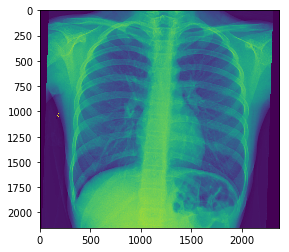

In [8]:
img = plt.imread(f'{PATH}valid/NORMAL/{files[1]}')
plt.imshow(img);

In [9]:
img.shape
# img[:2, :2]

(2152, 2366)

In [10]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

### Model: ResNet34

In [11]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.209544   0.577511   0.794872  
    1      0.15674    0.533342   0.810897                  
    2      0.126813   0.620677   0.804487                  



[array([0.62068]), 0.8044871810155038]

In [12]:
data.classes

['NORMAL', 'PNEUMONIA']

In [13]:
log_preds = learn.predict()
log_preds.shape
# log_pred[:10]

(624, 2)

In [14]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(Pneumonia)

In [15]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [16]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [17]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [18]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [19]:
# ## A few correct labels at Random
# plot_val_with_title(rand_by_correct(True), "Correctly classified")

# ##2. A few incorrect labels at random
# plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [20]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [21]:
# plot_val_with_title(most_by_correct(0, True), "Most correct Normal")
# plot_val_with_title(most_by_correct(1, True), "Most correct Pneumonia")

# plot_val_with_title(most_by_correct(0, False), "Most incorrect Normal")
# plot_val_with_title(most_by_correct(1, False), "Most incorrect Pneumonia")

# most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
# plot_val_with_title(most_uncertain, "Most uncertain predictions")

 93%|█████████▎| 76/82 [00:01<00:00, 46.86it/s, loss=2.94] 


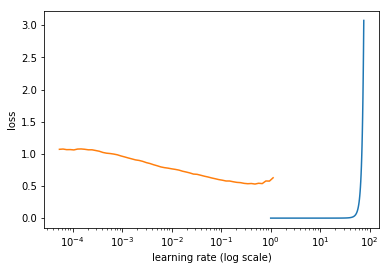

In [22]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

learn.sched.plot_lr()
learn.sched.plot()

### Data Augmentation

In [23]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

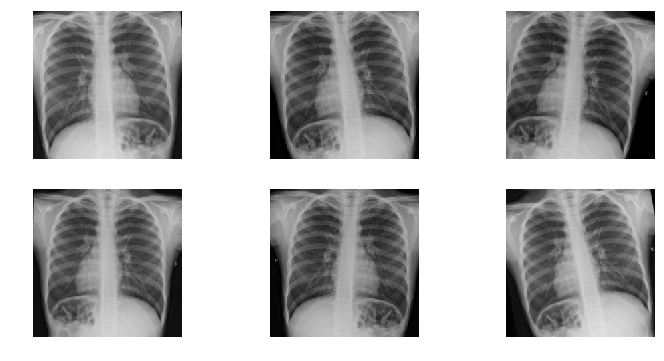

In [25]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [26]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [27]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.211539   0.592906   0.788462  
    1      0.136795   0.552882   0.820513                  



[array([0.55288]), 0.8205128189844962]

In [28]:
learn.precompute=False

In [29]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.161976   0.362815   0.858974  
    1      0.141639   0.359974   0.862179                  
    2      0.140138   0.351238   0.860577                  



[array([0.35124]), 0.8605769230769231]

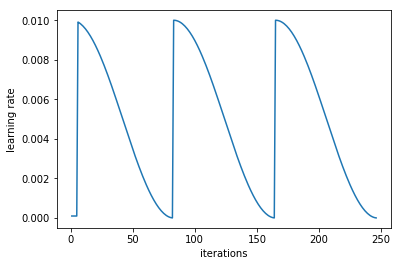

In [30]:
learn.sched.plot_lr()

In [31]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')

In [32]:
learn.unfreeze()

In [33]:
lr=np.array([1e-4,1e-3,1e-2])

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.157881   0.366245   0.871795  
    1      0.112489   0.327953   0.886218                  
    2      0.092096   0.345435   0.883013                   
    3      0.078478   0.342698   0.889423                   
    4      0.070172   0.338533   0.903846                   
    5      0.064632   0.350766   0.892628                   
    6      0.063977   0.363673   0.887821                   



[array([0.36367]), 0.887820514348837]

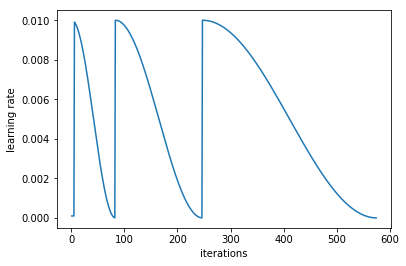

In [35]:
learn.sched.plot_lr()

In [36]:
learn.save('224_all')
learn.load('224_all')

In [37]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [38]:
accuracy_np(probs, y)

0.8461538461538461

In [39]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[140  94]
 [  2 388]]


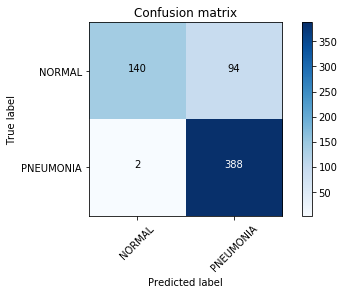

In [41]:
plot_confusion_matrix(cm, data.classes)